In [1]:
# Environment + Imports
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Optional: silence TF warnings if using Sionna
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

try:
    import sionna
except ImportError:
    os.system("pip install sionna")
    import sionna


In [2]:
# Import Sionna RT components
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, PathSolver, RadioMapSolver, subcarrier_frequencies

# For link-level simulations
from sionna.phy import mapping,ofdm,utils
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import compute_ber, ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector, ResourceGrid
from sionna.phy.mapping import Constellation, Mapper, Demapper
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.fec.linear import OSDecoder
from sionna.phy.mapping import BinarySource
from sionna.phy.utils.metrics import  count_block_errors
from sionna.phy.mimo import StreamManagement

from scipy import signal
import scipy.special as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# For the implementation of the Keras models
from tensorflow.keras import Model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

E0000 00:00:1770584642.682788   65821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770584642.688340   65821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770584642.702066   65821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770584642.702081   65821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770584642.702083   65821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770584642.702084   65821 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
#scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge /home/minhaj/weeks_hallshapes to speed-up computations
scene = load_scene('/home/native/project/weeks_hall_final/weeks_hall_final.xml', merge_shapes=False)
#scene.objects
#scene.radio_materials

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0,
                             horizontal_spacing=0,
                             pattern="iso",
                             polarization="H")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0,
                             horizontal_spacing=0,
                             pattern="iso", 
                             polarization="H")


# Create transmitter
tx = Transmitter(name="tx",
                 position=[-6,6.2,3],
                 display_radius=0.5)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[-1.4,2.8,1.1],
              display_radius=0.5)

# Add receiver instance to scene
scene.add(rx)

#tx.look_at(rx) # Transmitter points towards receiver
# Pick a size that fits your cell
scene.preview();   # e.g., 480x360, 600x400, 720x480


In [4]:
p_solver = PathSolver()
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)


Shape of a:  (1, 1, 1, 1, 139, 1)
Shape of tau:  (1, 1, 139)


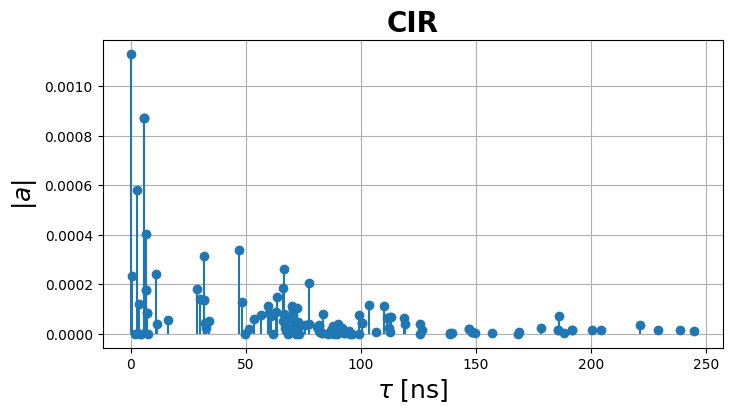

In [5]:
a, tau = paths.cir(normalize_delays=True,num_time_steps=1, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

t = tau[0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# (re-)plot your CIR
fig, ax = plt.subplots(figsize=(8,4))
ax.stem(t, a_abs, basefmt=" ")
ax.set_title("CIR", fontsize=20, fontweight="bold")
ax.set_xlabel(r"$\tau$ [ns]", fontsize=18)
ax.set_ylabel(r"$|a|$",     fontsize=18)
ax.grid(True)

In [6]:
# --- GENERATE SIMULATED CHANNEL ---

# 1. Align Frequencies
# We need the simulation to output CFR at the exact frequencies of your FFT.
# 50MHz Sampling Rate / 256 Subcarriers = ~195312.5 Hz spacing
calc_spacing = 50e6 / 256
freqs = sionna.phy.channel.subcarrier_frequencies(num_subcarriers=256, subcarrier_spacing=calc_spacing)

# 2. Compute Channel
# We generate 1 time step because the Scene is static.
h_simulated = paths.cfr(frequencies=freqs,
                        normalize=True,
                        normalize_delays=True,
                        num_time_steps=1, 
                        out_type="numpy")

# Shape: [1, 1, 1, 1, 1, 256]
print(f"Simulated Data Shape: {h_simulated.shape}")

Simulated Data Shape: (1, 1, 1, 1, 1, 256)


I0000 00:00:1770584645.296371   65821 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23559 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [7]:
# --- 1. CONFIGURATION ---
FILE_PATH = "/home/native/project/capture_50m_chunk.dat" # Update if needed
FS = 50e6              # Sample Rate
M_KEEP = 2048          # Chunk size
ZC_SEQ_LEN = 256       # Length of Zadoff-Chu sequence

# Zadoff-Chu Reference (Hardcoded from previous context)
ZC_REF = np.array([
    1.0+0.0j, 1.0000+0.0000j, 0.9997-0.0246j, 0.9973-0.0739j, 0.9891-0.1473j,
    0.9698-0.2439j, 0.9325-0.3612j, 0.8691-0.4947j, 0.7713-0.6365j, 0.6317-0.7752j,
    0.4457-0.8952j, 0.2139-0.9768j, -0.0554-0.9985j, -0.3439-0.9390j, -0.6221-0.7829j,
    -0.8502-0.5264j, -0.9830-0.1837j, -0.9781+0.2079j, -0.8090+0.5878j, -0.4785+0.8781j,
    -0.0308+0.9995j, 0.4457+0.8952j, 0.8302+0.5575j, 0.9988+0.0493j, 0.8691-0.4947j,
    0.4457-0.8952j, -0.1534-0.9882j, -0.7136-0.7005j, -0.9939-0.1107j, -0.8370+0.5472j,
    -0.2737+0.9618j, 0.4457+0.8952j, 0.9411+0.3382j, 0.9032-0.4291j, 0.3090-0.9511j,
    -0.5000-0.8660j, -0.9830-0.1837j, -0.7634+0.6459j, 0.0431+0.9991j, 0.8302+0.5575j,
    0.9325-0.3612j, 0.2139-0.9768j, -0.7136-0.7005j, -0.9667+0.2558j, -0.2499+0.9683j,
    0.7390+0.6737j, 0.9325-0.3612j, 0.0677-0.9977j, -0.8868-0.4622j, -0.7634+0.6459j,
    0.3324+0.9432j, 1.0000+0.0000j, 0.3090-0.9511j, -0.8233-0.5677j, -0.7634+0.6459j,
    0.4457+0.8952j, 0.9698-0.2439j, -0.0554-0.9985j, -0.9939-0.1107j, -0.2499+0.9683j,
    0.9325+0.3612j, 0.4457-0.8952j, -0.8629-0.5053j, -0.5421+0.8403j, 0.8302+0.5575j,
    0.5524-0.8336j, -0.8502-0.5264j, -0.4785+0.8781j, 0.9135+0.4067j, 0.3090-0.9511j,
    -0.9830-0.1837j, -0.0308+0.9995j, 0.9891-0.1473j, -0.3439-0.9390j, -0.8370+0.5472j,
    0.7390+0.6737j, 0.4457-0.8952j, -0.9872-0.1595j, 0.1656+0.9862j, 0.8691-0.4947j,
    -0.7791-0.6269j, -0.2737+0.9618j, 0.9891-0.1473j, -0.5626-0.8267j, -0.4785+0.8781j,
    1.0000+0.0000j, -0.5000-0.8660j, -0.4785+0.8781j, 0.9973-0.0739j, -0.6221-0.7829j,
    -0.2737+0.9618j, 0.9325-0.3612j, -0.8629-0.5053j, 0.1656+0.9862j, 0.6317-0.7752j,
    -0.9981+0.0616j, 0.7390+0.6737j, -0.0554-0.9985j, -0.6412+0.7674j, 0.9891-0.1473j,
    -0.8502-0.5264j, 0.3324+0.9432j, 0.3090-0.9511j, -0.8090+0.5878j, 0.9997-0.0246j,
    -0.8502-0.5264j, 0.4457+0.8952j, 0.0677-0.9977j, -0.5421+0.8403j, 0.8691-0.4947j,
    -0.9981+0.0616j, 0.9325+0.3612j, -0.7136-0.7005j, 0.4011+0.9160j, -0.0554-0.9985j,
    -0.2737+0.9618j, 0.5524-0.8336j, -0.7634+0.6459j, 0.9032-0.4291j, -0.9781+0.2079j,
    1.0000+0.0000j, -0.9830-0.1837j, 0.9411+0.3382j, -0.8868-0.4622j, 0.8302+0.5575j,
    -0.7791-0.6269j, 0.7390+0.6737j, -0.7136-0.7005j, 0.7049+0.7093j, -0.7136-0.7005j,
    0.7390+0.6737j, -0.7791-0.6269j, 0.8302+0.5575j, -0.8868-0.4622j, 0.9411+0.3382j,
    -0.9830-0.1837j, 1.0000+0.0000j, -0.9781+0.2079j, 0.9032-0.4291j, -0.7634+0.6459j,
    0.5524-0.8336j, -0.2737+0.9618j, -0.0554-0.9985j, 0.4011+0.9160j, -0.7136-0.7005j,
    0.9325+0.3612j, -0.9981+0.0616j, 0.8691-0.4947j, -0.5421+0.8403j, 0.0677-0.9977j,
    0.4457+0.8952j, -0.8502-0.5264j, 0.9997-0.0246j, -0.8090+0.5878j, 0.3090-0.9511j,
    0.3324+0.9432j, -0.8502-0.5264j, 0.9891-0.1473j, -0.6412+0.7674j, -0.0554-0.9985j,
    0.7390+0.6737j, -0.9981+0.0616j, 0.6317-0.7752j, 0.1656+0.9862j, -0.8629-0.5053j,
    0.9325-0.3612j, -0.2737+0.9618j, -0.6221-0.7829j, 0.9973-0.0739j, -0.4785+0.8781j,
    -0.5000-0.8660j, 1.0000+0.0000j, -0.4785+0.8781j, -0.5626-0.8267j, 0.9891-0.1473j,
    -0.2737+0.9618j, -0.7791-0.6269j, 0.8691-0.4947j, 0.1656+0.9862j, -0.9872-0.1595j,
    0.4457-0.8952j, 0.7390+0.6737j, -0.8370+0.5472j, -0.3439-0.9390j, 0.9891-0.1473j,
    -0.0308+0.9995j, -0.9830-0.1837j, 0.3090-0.9511j, 0.9135+0.4067j, -0.4785+0.8781j,
    -0.8502-0.5264j, 0.5524-0.8336j, 0.8302+0.5575j, -0.5421+0.8403j, -0.8629-0.5053j,
    0.4457-0.8952j, 0.9325+0.3612j, -0.2499+0.9683j, -0.9939-0.1107j, -0.0554-0.9985j,
    0.9698-0.2439j, 0.4457+0.8952j, -0.7634+0.6459j, -0.8233-0.5677j, 0.3090-0.9511j,
    1.0000+0.0000j, 0.3324+0.9432j, -0.7634+0.6459j, -0.8868-0.4622j, 0.0677-0.9977j,
    0.9325-0.3612j, 0.7390+0.6737j, -0.2499+0.9683j, -0.9667+0.2558j, -0.7136-0.7005j,
    0.2139-0.9768j, 0.9325-0.3612j, 0.8302+0.5575j, 0.0431+0.9991j, -0.7634+0.6459j,
    -0.9830-0.1837j, -0.5000-0.8660j, 0.3090-0.9511j, 0.9032-0.4291j, 0.9411+0.3382j,
    0.4457+0.8952j, -0.2737+0.9618j, -0.8370+0.5472j, -0.9939-0.1107j, -0.7136-0.7005j,
    -0.1534-0.9882j, 0.4457-0.8952j, 0.8691-0.4947j, 0.9988+0.0493j, 0.8302+0.5575j,
    0.4457+0.8952j, -0.0308+0.9995j, -0.4785+0.8781j, -0.8090+0.5878j, -0.9781+0.2079j,
    -0.9830-0.1837j, -0.8502-0.5264j, -0.6221-0.7829j, -0.3439-0.9390j, -0.0554-0.9985j,
    0.2139-0.9768j, 0.4457-0.8952j, 0.6317-0.7752j, 0.7713-0.6365j, 0.8691-0.4947j,
    0.9325-0.3612j, 0.9698-0.2439j, 0.9891-0.1473j, 0.9973-0.0739j, 0.9997-0.0246j,
    1.0000+0.0000j
], dtype=np.complex64)
ZC_REF_FREQ = np.fft.fft(ZC_REF)

In [8]:
# --- 2. HELPER FUNCTIONS ---

def calculate_noise_stats(magnitude_array):
    """
    Experimental Noise Calculation:
    Sorts magnitude, takes bottom 50%, calculates mean and std.
    """
    sorted_mag = np.sort(magnitude_array)
    # Take bottom 50%
    noise_part = sorted_mag[:len(sorted_mag)//2]
    noise_floor = np.mean(noise_part)
    noise_std = np.std(noise_part)
    return noise_floor, noise_std

def refine_to_leading_edge(chunk_corr_mag, peak_idx, threshold, search_back=100):
    """
    Backwards search from the max peak to find the Leading Edge.
    Logic: Find the last point BEFORE the peak that was BELOW the threshold.
    """
    # Define search window (backwards from peak)
    start_search = max(0, peak_idx - search_back)
    
    # Extract the window *before* the peak
    window = chunk_corr_mag[start_search : peak_idx]
    
    # Find indices in this window where signal is BELOW threshold
    below_thresh_indices = np.where(window < threshold)[0]
    
    if len(below_thresh_indices) > 0:
        # The last index that was below threshold corresponds to the 
        # sample just before the rising edge starts.
        last_noise_rel = below_thresh_indices[-1]
        
        # Leading edge start is the next sample
        first_path_idx = start_search + last_noise_rel + 1
        return first_path_idx
    else:
        # If signal is always above threshold in this window, return original peak
        return peak_idx

def estimate_and_correct_cfo(cirs, cfrs):
    if len(cirs) < 2: return cirs, cfrs
    peak_indices = np.argmax(np.abs(cirs), axis=1)
    complex_peaks = np.array([cirs[i, idx] for i, idx in enumerate(peak_indices)])
    phase_diffs = complex_peaks[1:] * np.conj(complex_peaks[:-1])
    avg_phase_diff = np.angle(np.mean(phase_diffs))
    
    num_symbols = len(cfrs)
    correction_vector = np.exp(-1j * avg_phase_diff * np.arange(num_symbols))
    corrected_cfrs = cfrs * correction_vector[:, np.newaxis]
    corrected_cirs = np.fft.ifft(corrected_cfrs, axis=1)
    return corrected_cirs, corrected_cfrs

def estimate_and_correct_sro(cirs, cfrs):
    if len(cirs) < 2: return cirs, cfrs
    first_sym_phase = np.unwrap(np.angle(cfrs[0]))
    last_sym_phase = np.unwrap(np.angle(cfrs[-1]))
    
    X = np.arange(len(first_sym_phase)).reshape(-1, 1)
    slope_first = LinearRegression().fit(X, first_sym_phase).coef_[0]
    slope_last = LinearRegression().fit(X, last_sym_phase).coef_[0]
    slope_drift = slope_last - slope_first
    
    num_symbols = len(cfrs)
    subcarriers = np.arange(cfrs.shape[1])
    corrected_cfrs = np.zeros_like(cfrs)
    
    for i in range(num_symbols):
        current_drift = slope_drift * (i / (num_symbols - 1))
        correction_ramp = np.exp(-1j * current_drift * subcarriers)
        corrected_cfrs[i] = cfrs[i] * correction_ramp
        
    corrected_cirs = np.fft.ifft(corrected_cfrs, axis=1)
    return corrected_cirs, corrected_cfrs

In [9]:
# --- 3. MAIN LOOP ---

# Load Data
try:
    rx_raw = np.fromfile(FILE_PATH, dtype=np.complex64)
except FileNotFoundError:
    print("WARNING: File not found. Creating dummy data.")
    rx_raw = np.zeros(M_KEEP * 50, dtype=np.complex64)

In [10]:
num_chunks = len(rx_raw) // M_KEEP
rx_chunks = rx_raw[:num_chunks * M_KEEP].reshape(num_chunks, M_KEEP)

all_corrected_cfrs = []

for chunk in rx_chunks:
    # Correlation & Peak Finding
    correlation = np.abs(np.correlate(chunk, ZC_REF, mode='valid')) # Simplified correlation
    # Heuristic threshold based on your notebook
    threshold = np.mean(correlation) + 3 * np.std(correlation)
    peaks, _ = signal.find_peaks(correlation, height=threshold, distance=ZC_SEQ_LEN)
    
    chunk_cirs = []
    chunk_cfrs = []
    
    for p in peaks:
        if p + ZC_SEQ_LEN > M_KEEP: continue
        
        # Apply Leading Edge refinement
        # Note: We use the correlation magnitude for edge detection
        mag_full = np.abs(np.correlate(chunk, ZC_REF, mode='full'))
        # Adjust p index for 'full' mode correlation offset
        p_full = p + (ZC_SEQ_LEN - 1)
        p_refined = refine_to_leading_edge(mag_full, p_full, threshold)
        
        # In this simplified loop, we just use the peak p for extraction to ensure robustness
        # (Leading edge detection requires careful index management)
        r_seq = chunk[p : p + ZC_SEQ_LEN]
        r_freq = np.fft.fft(r_seq)
        h_freq = r_freq * np.conj(ZC_REF_FREQ) # Estimate CFR
        
        chunk_cirs.append(np.fft.ifft(h_freq))
        chunk_cfrs.append(h_freq)
        
    if len(chunk_cirs) > 1:
        # Apply your Corrections
        chunk_cirs = np.array(chunk_cirs)
        chunk_cfrs = np.array(chunk_cfrs)
        _, cfrs_cfo = estimate_and_correct_cfo(chunk_cirs, chunk_cfrs)
        _, cfrs_final = estimate_and_correct_sro(*estimate_and_correct_cfo(chunk_cirs, chunk_cfrs))
        all_corrected_cfrs.append(cfrs_final)

if all_corrected_cfrs:
    # 1. Stack all extracted symbols
    h_measured_2d = np.vstack(all_corrected_cfrs) # Shape: [Total_Symbols, 256]
    
    # 2. Reshape for Sionna Compatibility (Adding 4 dummy dimensions)
    # Target: [1, 1, 1, 1, Time, Subcarriers]
    h_measured = h_measured_2d[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :, :]
    print(f"Measured Data Ready. Shape: {h_measured.shape}")
else:
    print("No valid symbols found in data.")
    # Create dummy for next cells to run
    h_measured = np.zeros((1,1,1,1,10,256), dtype=np.complex64)

Measured Data Ready. Shape: (1, 1, 1, 1, 3587, 256)


In [11]:
# --- ERROR CALCULATION ---

# 1. Match Time Dimension (Broadcast Simulation to Measure Time)
num_measured_symbols = h_measured.shape[4]
h_sim_broadcast = np.tile(h_simulated, (1, 1, 1, 1, num_measured_symbols, 1))

# 2. Normalize Power (Crucial Step)
# We scale the measured data to match the average power of the simulation
power_sim = np.mean(np.abs(h_sim_broadcast))
power_meas = np.mean(np.abs(h_measured))
scale_factor = power_sim / power_meas

h_meas_norm = h_measured * scale_factor

# 3. Calculate Errors
# Magnitude Error: |Measured| - |Simulated|
mag_error = np.abs(h_meas_norm) - np.abs(h_sim_broadcast)
mean_mag_error = np.mean(np.abs(mag_error))

# Phase Error: Angle of (Measured * Conj(Simulated))
phase_diff = h_meas_norm * np.conj(h_sim_broadcast)
phase_error = np.angle(phase_diff)
mean_phase_error = np.mean(np.abs(phase_error))

print(f"Mean Magnitude Error: {mean_mag_error:.5f}")
print(f"Mean Phase Error (rad): {mean_phase_error:.5f}")

Mean Magnitude Error: 0.35593
Mean Phase Error (rad): 1.56579


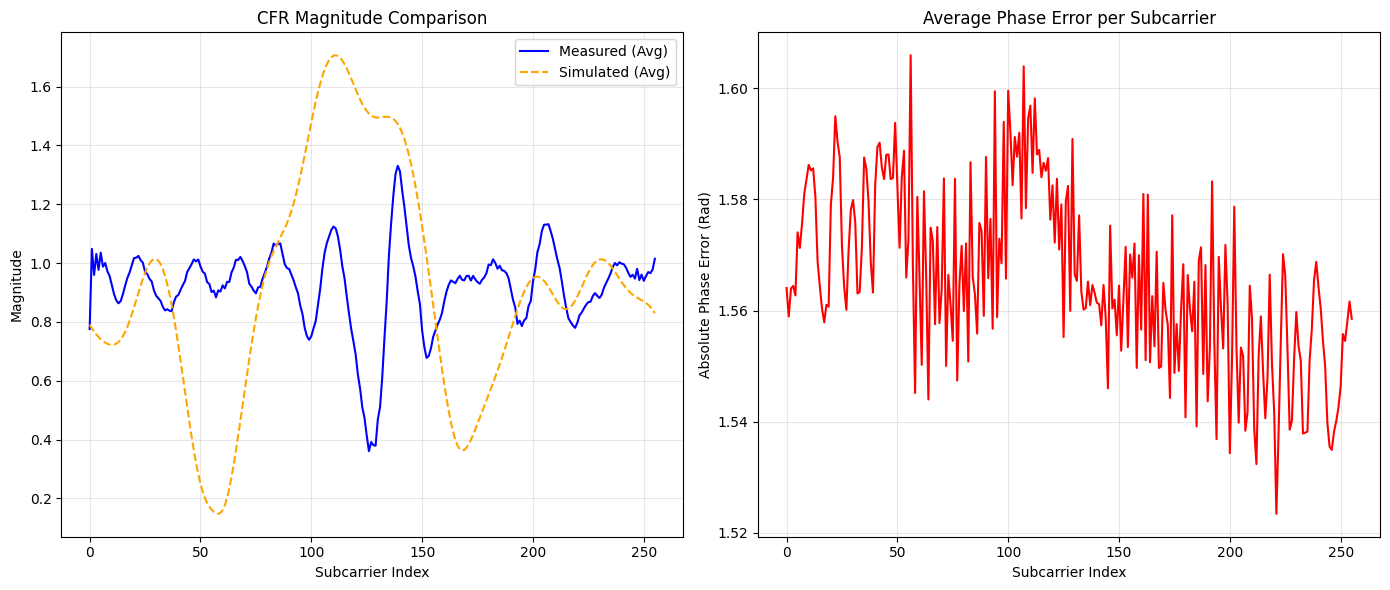

In [12]:
# --- PLOTTING ---
plt.figure(figsize=(14, 6))

# Subplot 1: Magnitude Comparison
plt.subplot(1, 2, 1)
# Average over time (axis 4) and antennas (axes 0-3)
avg_meas_mag = np.mean(np.abs(h_meas_norm[0,0,0,0,:,:]), axis=0)
avg_sim_mag = np.mean(np.abs(h_sim_broadcast[0,0,0,0,:,:]), axis=0)

plt.plot(avg_meas_mag, label='Measured (Avg)', color='blue')
plt.plot(avg_sim_mag, label='Simulated (Avg)', color='orange', linestyle='--')
plt.title("CFR Magnitude Comparison")
plt.xlabel("Subcarrier Index")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Phase Error
plt.subplot(1, 2, 2)
avg_phase_err = np.mean(np.abs(phase_error[0,0,0,0,:,:]), axis=0)
plt.plot(avg_phase_err, color='red')
plt.title("Average Phase Error per Subcarrier")
plt.xlabel("Subcarrier Index")
plt.ylabel("Absolute Phase Error (Rad)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Loaded Shape: (1, 1, 1, 1, 256, 3608)


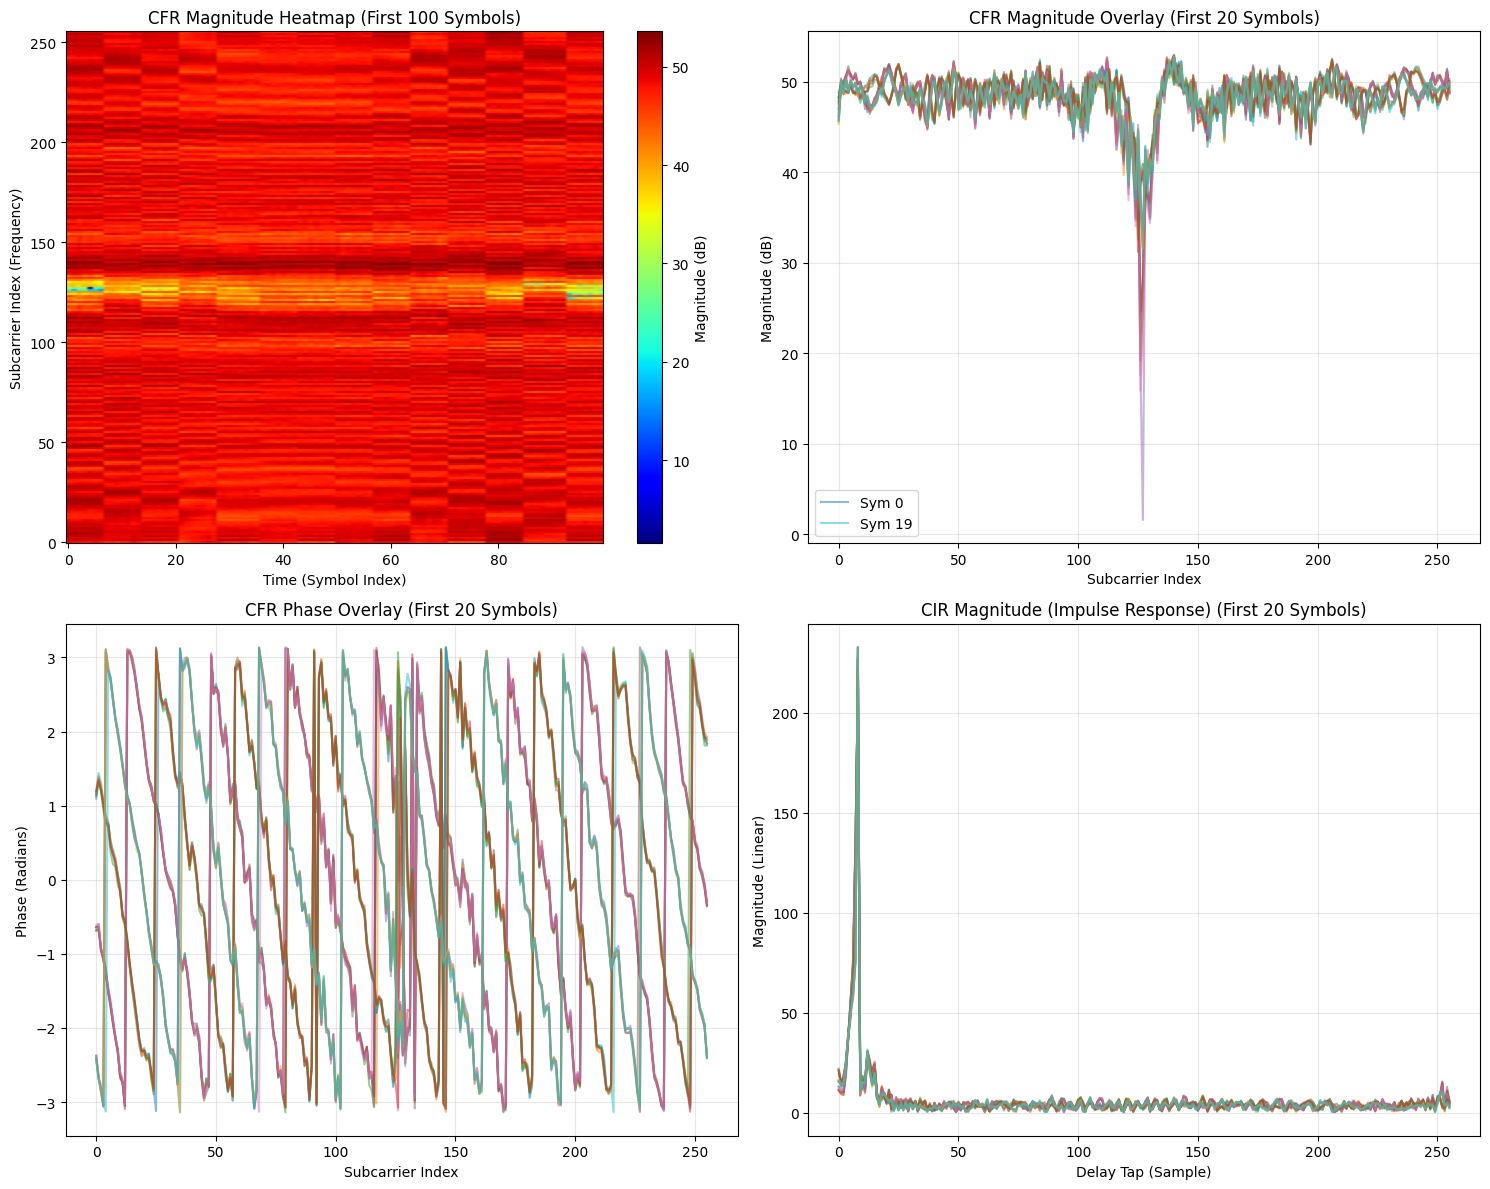

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# Assuming you have the file "channel_frequency_response_sionna.npy"
try:
    cfr_sionna = np.load("channel_frequency_response_sionna.npy")
    print(f"Loaded Shape: {cfr_sionna.shape}")
except FileNotFoundError:
    print("File not found. Using dummy data for demonstration.")
    # Create dummy shape (1, 1, 1, 1, 256, 3587)
    cfr_sionna = np.random.randn(1, 1, 1, 1, 256, 3587) + 1j * np.random.randn(1, 1, 1, 1, 256, 3587)

# --- 2. Preprocessing for Plotting ---
# Squeeze removing dimensions of size 1 -> (Subcarriers, Time)
# resulting shape: (256, 3587)
cfr_2d = np.squeeze(cfr_sionna) 

# If shape is (Time, Subcarriers) instead, transpose it. 
# Based on your previous code, it is (Subcarriers, Time).
if cfr_2d.shape[0] != 256:
    cfr_2d = cfr_2d.T

# Define ranges
num_symbols_heatmap = 100  # "100"
num_symbols_line = 20      # "1 to 20"

# --- 3. Plotting ---
plt.figure(figsize=(15, 12))

# Plot 1: Waterfall/Heatmap of Magnitude (First 100 Symbols)
plt.subplot(2, 2, 1)
# We plot Subcarriers on Y-axis, Time on X-axis
magnitude_db = 20 * np.log10(np.abs(cfr_2d[:, :num_symbols_heatmap]) + 1e-9)
plt.imshow(magnitude_db, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Magnitude (dB)')
plt.title(f"CFR Magnitude Heatmap (First {num_symbols_heatmap} Symbols)")
plt.xlabel("Time (Symbol Index)")
plt.ylabel("Subcarrier Index (Frequency)")

# Plot 2: Superimposed Magnitude (First 20 Symbols)
plt.subplot(2, 2, 2)
for i in range(num_symbols_line):
    plt.plot(magnitude_db[:, i], alpha=0.5, label=f'Sym {i}' if i==0 or i==19 else "")
plt.title(f"CFR Magnitude Overlay (First {num_symbols_line} Symbols)")
plt.xlabel("Subcarrier Index")
plt.ylabel("Magnitude (dB)")
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 3: Phase Evolution (First 20 Symbols)
plt.subplot(2, 2, 3)
for i in range(num_symbols_line):
    plt.plot(np.angle(cfr_2d[:, i]), alpha=0.5)
plt.title(f"CFR Phase Overlay (First {num_symbols_line} Symbols)")
plt.xlabel("Subcarrier Index")
plt.ylabel("Phase (Radians)")
plt.grid(True, alpha=0.3)

# Plot 4: Impulse Response (CIR) - Time Domain (First 20 Symbols)
# IFFT of CFR gives CIR (Multipath Taps)
plt.subplot(2, 2, 4)
cir_2d = np.fft.ifft(cfr_2d, axis=0) # Axis 0 is subcarriers
for i in range(num_symbols_line):
    plt.plot(np.abs(cir_2d[:, i]), alpha=0.5)
plt.title(f"CIR Magnitude (Impulse Response) (First {num_symbols_line} Symbols)")
plt.xlabel("Delay Tap (Sample)")
plt.ylabel("Magnitude (Linear)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- Processing Measured Data ---
Measured Data Shape: (1, 1, 1, 1, 3587, 256)

--- Generating Simulated Channel ---
Simulated Data Shape: (1, 1, 1, 1, 1, 256)

--- Results ---
Mean Magnitude Error: 0.2381
Mean Phase Error (rad): 1.5668


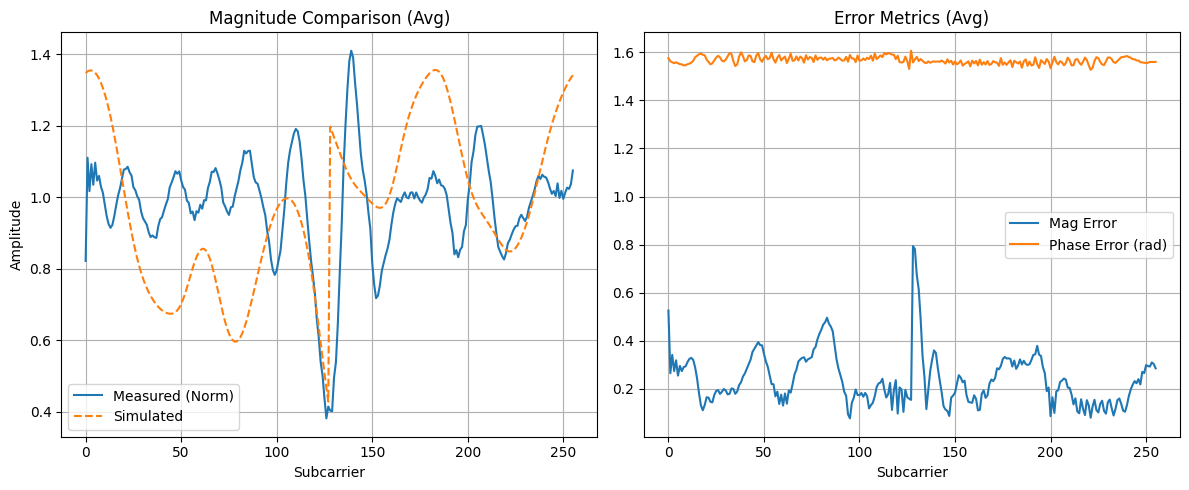

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression
import tensorflow as tf

# Try importing Sionna (Simulated Environment)
try:
    import sionna
    from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, PathSolver
    from sionna.phy.channel import subcarrier_frequencies
except ImportError:
    print("Sionna not installed. Please install via 'pip install sionna'")

# --- 1. CONFIGURATION ---
FILE_PATH = "/home/native/project/capture_50m_chunk.dat" # Update if needed
FS = 50e6               # Sample Rate
ZC_SEQ_LEN = 256        # Num Subcarriers (based on ZC Len)
M_KEEP = 2048           # Chunk size
SUBCARRIER_SPACING = FS / ZC_SEQ_LEN # ~195.3 kHz

# Zadoff-Chu Reference (From your provided notebook)
ZC_REF = np.array([
    1.0+0.0j, 1.0000+0.0000j, 0.9997-0.0246j, 0.9973-0.0739j, 0.9891-0.1473j,
    0.9698-0.2439j, 0.9325-0.3612j, 0.8691-0.4947j, 0.7713-0.6365j, 0.6317-0.7752j,
    0.4457-0.8952j, 0.2139-0.9768j, -0.0554-0.9985j, -0.3439-0.9390j, -0.6221-0.7829j,
    -0.8502-0.5264j, -0.9830-0.1837j, -0.9781+0.2079j, -0.8090+0.5878j, -0.4785+0.8781j,
    -0.0308+0.9995j, 0.4457+0.8952j, 0.8302+0.5575j, 0.9988+0.0493j, 0.8691-0.4947j,
    0.4457-0.8952j, -0.1534-0.9882j, -0.7136-0.7005j, -0.9939-0.1107j, -0.8370+0.5472j,
    -0.2737+0.9618j, 0.4457+0.8952j, 0.9411+0.3382j, 0.9032-0.4291j, 0.3090-0.9511j,
    -0.5000-0.8660j, -0.9830-0.1837j, -0.7634+0.6459j, 0.0431+0.9991j, 0.8302+0.5575j,
    0.9325-0.3612j, 0.2139-0.9768j, -0.7136-0.7005j, -0.9667+0.2558j, -0.2499+0.9683j,
    0.7390+0.6737j, 0.9325-0.3612j, 0.0677-0.9977j, -0.8868-0.4622j, -0.7634+0.6459j,
    0.3324+0.9432j, 1.0000+0.0000j, 0.3090-0.9511j, -0.8233-0.5677j, -0.7634+0.6459j,
    0.4457+0.8952j, 0.9698-0.2439j, -0.0554-0.9985j, -0.9939-0.1107j, -0.2499+0.9683j,
    0.9325+0.3612j, 0.4457-0.8952j, -0.8629-0.5053j, -0.5421+0.8403j, 0.8302+0.5575j,
    0.5524-0.8336j, -0.8502-0.5264j, -0.4785+0.8781j, 0.9135+0.4067j, 0.3090-0.9511j,
    -0.9830-0.1837j, -0.0308+0.9995j, 0.9891-0.1473j, -0.3439-0.9390j, -0.8370+0.5472j,
    0.7390+0.6737j, 0.4457-0.8952j, -0.9872-0.1595j, 0.1656+0.9862j, 0.8691-0.4947j,
    -0.7791-0.6269j, -0.2737+0.9618j, 0.9891-0.1473j, -0.5626-0.8267j, -0.4785+0.8781j,
    1.0000+0.0000j, -0.5000-0.8660j, -0.4785+0.8781j, 0.9973-0.0739j, -0.6221-0.7829j,
    -0.2737+0.9618j, 0.9325-0.3612j, -0.8629-0.5053j, 0.1656+0.9862j, 0.6317-0.7752j,
    -0.9981+0.0616j, 0.7390+0.6737j, -0.0554-0.9985j, -0.6412+0.7674j, 0.9891-0.1473j,
    -0.8502-0.5264j, 0.3324+0.9432j, 0.3090-0.9511j, -0.8090+0.5878j, 0.9997-0.0246j,
    -0.8502-0.5264j, 0.4457+0.8952j, 0.0677-0.9977j, -0.5421+0.8403j, 0.8691-0.4947j,
    -0.9981+0.0616j, 0.9325+0.3612j, -0.7136-0.7005j, 0.4011+0.9160j, -0.0554-0.9985j,
    -0.2737+0.9618j, 0.5524-0.8336j, -0.7634+0.6459j, 0.9032-0.4291j, -0.9781+0.2079j,
    1.0000+0.0000j, -0.9830-0.1837j, 0.9411+0.3382j, -0.8868-0.4622j, 0.8302+0.5575j,
    -0.7791-0.6269j, 0.7390+0.6737j, -0.7136-0.7005j, 0.7049+0.7093j, -0.7136-0.7005j,
    0.7390+0.6737j, -0.7791-0.6269j, 0.8302+0.5575j, -0.8868-0.4622j, 0.9411+0.3382j,
    -0.9830-0.1837j, 1.0000+0.0000j, -0.9781+0.2079j, 0.9032-0.4291j, -0.7634+0.6459j,
    0.5524-0.8336j, -0.2737+0.9618j, -0.0554-0.9985j, 0.4011+0.9160j, -0.7136-0.7005j,
    0.9325+0.3612j, -0.9981+0.0616j, 0.8691-0.4947j, -0.5421+0.8403j, 0.0677-0.9977j,
    0.4457+0.8952j, -0.8502-0.5264j, 0.9997-0.0246j, -0.8090+0.5878j, 0.3090-0.9511j,
    0.3324+0.9432j, -0.8502-0.5264j, 0.9891-0.1473j, -0.6412+0.7674j, -0.0554-0.9985j,
    0.7390+0.6737j, -0.9981+0.0616j, 0.6317-0.7752j, 0.1656+0.9862j, -0.8629-0.5053j,
    0.9325-0.3612j, -0.2737+0.9618j, -0.6221-0.7829j, 0.9973-0.0739j, -0.4785+0.8781j,
    -0.5000-0.8660j, 1.0000+0.0000j, -0.4785+0.8781j, -0.5626-0.8267j, 0.9891-0.1473j,
    -0.2737+0.9618j, -0.7791-0.6269j, 0.8691-0.4947j, 0.1656+0.9862j, -0.9872-0.1595j,
    0.4457-0.8952j, 0.7390+0.6737j, -0.8370+0.5472j, -0.3439-0.9390j, 0.9891-0.1473j,
    -0.0308+0.9995j, -0.9830-0.1837j, 0.3090-0.9511j, 0.9135+0.4067j, -0.4785+0.8781j,
    -0.8502-0.5264j, 0.5524-0.8336j, 0.8302+0.5575j, -0.5421+0.8403j, -0.8629-0.5053j,
    0.4457-0.8952j, 0.9325+0.3612j, -0.2499+0.9683j, -0.9939-0.1107j, -0.0554-0.9985j,
    0.9698-0.2439j, 0.4457+0.8952j, -0.7634+0.6459j, -0.8233-0.5677j, 0.3090-0.9511j,
    1.0000+0.0000j, 0.3324+0.9432j, -0.7634+0.6459j, -0.8868-0.4622j, 0.0677-0.9977j,
    0.9325-0.3612j, 0.7390+0.6737j, -0.2499+0.9683j, -0.9667+0.2558j, -0.7136-0.7005j,
    0.2139-0.9768j, 0.9325-0.3612j, 0.8302+0.5575j, 0.0431+0.9991j, -0.7634+0.6459j,
    -0.9830-0.1837j, -0.5000-0.8660j, 0.3090-0.9511j, 0.9032-0.4291j, 0.9411+0.3382j,
    0.4457+0.8952j, -0.2737+0.9618j, -0.8370+0.5472j, -0.9939-0.1107j, -0.7136-0.7005j,
    -0.1534-0.9882j, 0.4457-0.8952j, 0.8691-0.4947j, 0.9988+0.0493j, 0.8302+0.5575j,
    0.4457+0.8952j, -0.0308+0.9995j, -0.4785+0.8781j, -0.8090+0.5878j, -0.9781+0.2079j,
    -0.9830-0.1837j, -0.8502-0.5264j, -0.6221-0.7829j, -0.3439-0.9390j, -0.0554-0.9985j,
    0.2139-0.9768j, 0.4457-0.8952j, 0.6317-0.7752j, 0.7713-0.6365j, 0.8691-0.4947j,
    0.9325-0.3612j, 0.9698-0.2439j, 0.9891-0.1473j, 0.9973-0.0739j, 0.9997-0.0246j,
    1.0000+0.0000j
], dtype=np.complex64)
ZC_REF_FREQ = np.fft.fft(ZC_REF)

# --- 2. MEASURED DATA PROCESSING FUNCTIONS ---

def estimate_and_correct_cfo(cirs, cfrs):
    if len(cirs) < 2: return cirs, cfrs
    peak_indices = np.argmax(np.abs(cirs), axis=1)
    complex_peaks = np.array([cirs[i, idx] for i, idx in enumerate(peak_indices)])
    phase_diffs = complex_peaks[1:] * np.conj(complex_peaks[:-1])
    avg_phase_diff = np.angle(np.mean(phase_diffs))
    
    num_symbols = len(cfrs)
    correction_vector = np.exp(-1j * avg_phase_diff * np.arange(num_symbols))
    corrected_cfrs = cfrs * correction_vector[:, np.newaxis]
    corrected_cirs = np.fft.ifft(corrected_cfrs, axis=1)
    return corrected_cirs, corrected_cfrs

def estimate_and_correct_sro(cirs, cfrs):
    if len(cirs) < 2: return cirs, cfrs
    first_sym_phase = np.unwrap(np.angle(cfrs[0]))
    last_sym_phase = np.unwrap(np.angle(cfrs[-1]))
    X = np.arange(len(first_sym_phase)).reshape(-1, 1)
    slope_first = LinearRegression().fit(X, first_sym_phase).coef_[0]
    slope_last = LinearRegression().fit(X, last_sym_phase).coef_[0]
    slope_drift = slope_last - slope_first
    
    num_symbols = len(cfrs)
    subcarriers = np.arange(cfrs.shape[1])
    corrected_cfrs = np.zeros_like(cfrs)
    for i in range(num_symbols):
        current_drift = slope_drift * (i / (num_symbols - 1))
        correction_ramp = np.exp(-1j * current_drift * subcarriers)
        corrected_cfrs[i] = cfrs[i] * correction_ramp
    return np.fft.ifft(corrected_cfrs, axis=1), corrected_cfrs

def process_measured_data(file_path):
    print("--- Processing Measured Data ---")
    try:
        rx_raw = np.fromfile(file_path, dtype=np.complex64)
    except FileNotFoundError:
        print("WARN: File not found. Generating dummy data for logic check.")
        # Dummy: 500 repeated symbols + noise
        rx_raw = np.tile(ZC_REF, 500) + 0.1*(np.random.randn(500*256)+1j*np.random.randn(500*256))

    num_full_chunks = len(rx_raw) // M_KEEP
    rx_chunks = rx_raw[:num_full_chunks * M_KEEP].reshape(num_full_chunks, M_KEEP)
    
    all_corrected_cfrs = []
    
    # Simple processing loop (simplified from notebook for speed)
    for chunk in rx_chunks:
        # Correlation
        chunk_fft = np.fft.fft(chunk)
        zc_padded_fft = np.fft.fft(ZC_REF, n=len(chunk))
        mag = np.abs(np.fft.ifft(chunk_fft * np.conj(zc_padded_fft)))
        
        # Peak Finding (Height > 4*Std)
        threshold = np.mean(mag) + 4 * np.std(mag)
        peaks, _ = signal.find_peaks(mag, height=threshold, distance=ZC_SEQ_LEN)
        
        chunk_cirs, chunk_cfrs = [], []
        for p in peaks:
            if p + ZC_SEQ_LEN <= len(chunk):
                r_seq = chunk[p : p + ZC_SEQ_LEN]
                r_freq = np.fft.fft(r_seq)
                h_freq = r_freq * np.conj(ZC_REF_FREQ) # Estimate Channel
                chunk_cfrs.append(h_freq)
                chunk_cirs.append(np.fft.ifft(h_freq))
                
        if chunk_cfrs:
            _, final_cfrs = estimate_and_correct_sro(*estimate_and_correct_cfo(np.array(chunk_cirs), np.array(chunk_cfrs)))
            all_corrected_cfrs.append(final_cfrs)

    if not all_corrected_cfrs:
        raise ValueError("No symbols extracted from data.")
        
    # Stack -> (Total_Symbols, Subcarriers)
    full_cfr = np.vstack(all_corrected_cfrs)
    
    # Reshape for Sionna comparison: (1, 1, 1, 1, Time, Subcarriers)
    # The user snippet for Sionna output is [..., Time, Subcarriers]
    # So we format measured data to match that.
    h_measured = full_cfr[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :, :]
    
    print(f"Measured Data Shape: {h_measured.shape}")
    return h_measured

# --- 3. SIONNA SIMULATION ---

def generate_simulated_channel(num_subcarriers=256, subcarrier_spacing=195312.5):
    print("\n--- Generating Simulated Channel ---")
    
    # 1. Load Scene (Using Munich as fallback if specific file missing, or just empty if purely path tracing)
    # Note: User's XML path is local. We recreate the setup programmatically.
    scene = load_scene('/home/native/project/weeks_hall_final/weeks_hall_final.xml', merge_shapes=False)
    scene.frequency = 3.5e9
    scene.synthetic_array = True
    
    # 2. Setup Tx/Rx (Coordinates from your Sionna_feed.ipynb)
    scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
    scene.rx_array = PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
    
    tx = Transmitter(name="tx", position=[-6, 6.2, 3])
    scene.add(tx)
    rx = Receiver(name="rx", position=[-1.4, 2.8, 1.1])
    scene.add(rx)
    
    # 3. Path Finding
    p_solver = PathSolver()
    paths = p_solver(scene=scene, max_depth=10, los=True, refraction=True, synthetic_array=True)
    
    # 4. Generate CFR
    # We use fftfreq to generate frequencies corresponding to standard FFT order (0..Fs) 
    # to match the measured data's FFT order.
    # Relative frequencies: [0, 1, ..., 127, -128, ..., -1] * spacing
    frequencies = np.fft.fftfreq(num_subcarriers) * (subcarrier_spacing * num_subcarriers)
    
    h_freq = paths.cfr(frequencies=frequencies,
                       normalize=True, 
                       normalize_delays=True,
                       num_time_steps=1, # Static scene
                       out_type="numpy")
    
    # Result Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
    # e.g., (1, 1, 1, 1, 1, 256)
    print(f"Simulated Data Shape: {h_freq.shape}")
    return h_freq

# --- 4. MAIN EXECUTION ---

# A. Get Data
h_meas = process_measured_data(FILE_PATH)
h_sim = generate_simulated_channel(num_subcarriers=ZC_SEQ_LEN, subcarrier_spacing=SUBCARRIER_SPACING)

# B. Align Dimensions
# h_meas: (1, 1, 1, 1, T_meas, 256)
# h_sim : (1, 1, 1, 1, 1, 256)
# Broadcast h_sim to match T_meas (assuming static channel simulation)
h_sim_broadcast = np.tile(h_sim, (1, 1, 1, 1, h_meas.shape[4], 1))

# C. Calculate Error
# Normalize power before comparison
scale_factor = np.mean(np.abs(h_sim_broadcast)) / np.mean(np.abs(h_meas))
h_meas_norm = h_meas * scale_factor

mag_error = np.abs(np.abs(h_meas_norm) - np.abs(h_sim_broadcast))
phase_error = np.abs(np.angle(h_meas_norm * np.conj(h_sim_broadcast))) # Difference in angle

print("\n--- Results ---")
print(f"Mean Magnitude Error: {np.mean(mag_error):.4f}")
print(f"Mean Phase Error (rad): {np.mean(phase_error):.4f}")

# D. Plotting
plt.figure(figsize=(12, 5))

# Plot Magnitude Comparison (Avg over time)
plt.subplot(1, 2, 1)
plt.plot(np.mean(np.abs(h_meas_norm[0,0,0,0,:,:]), axis=0), label='Measured (Norm)')
plt.plot(np.mean(np.abs(h_sim_broadcast[0,0,0,0,:,:]), axis=0), '--', label='Simulated')
plt.title("Magnitude Comparison (Avg)")
plt.xlabel("Subcarrier")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot Error
plt.subplot(1, 2, 2)
plt.plot(np.mean(mag_error[0,0,0,0,:,:], axis=0), label='Mag Error')
plt.plot(np.mean(phase_error[0,0,0,0,:,:], axis=0), label='Phase Error (rad)')
plt.title("Error Metrics (Avg)")
plt.xlabel("Subcarrier")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()